In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

In [24]:
air_quality = pd.read_csv('air_quality.csv', index_col='Date')

#del air_quality['Unnamed: 0']

In [25]:
air_quality.index = pd.to_datetime(air_quality.index)
del air_quality['Unnamed: 0']
#air_quality = np.log(air_quality)
air_quality.head(10)

,AQI
Date,
2020-03-05,73.0
2020-03-06,55.0
2020-03-07,78.0
2020-03-08,120.0
2020-03-09,179.0
2020-03-10,224.0
2020-03-11,106.0
2020-03-12,140.0
2020-03-13,164.0


In [26]:
air_quality.isnull().sum()
air_quality.fillna(method='bfill', inplace=True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_20628\516553066.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  air_quality.fillna(method='bfill', inplace=True)


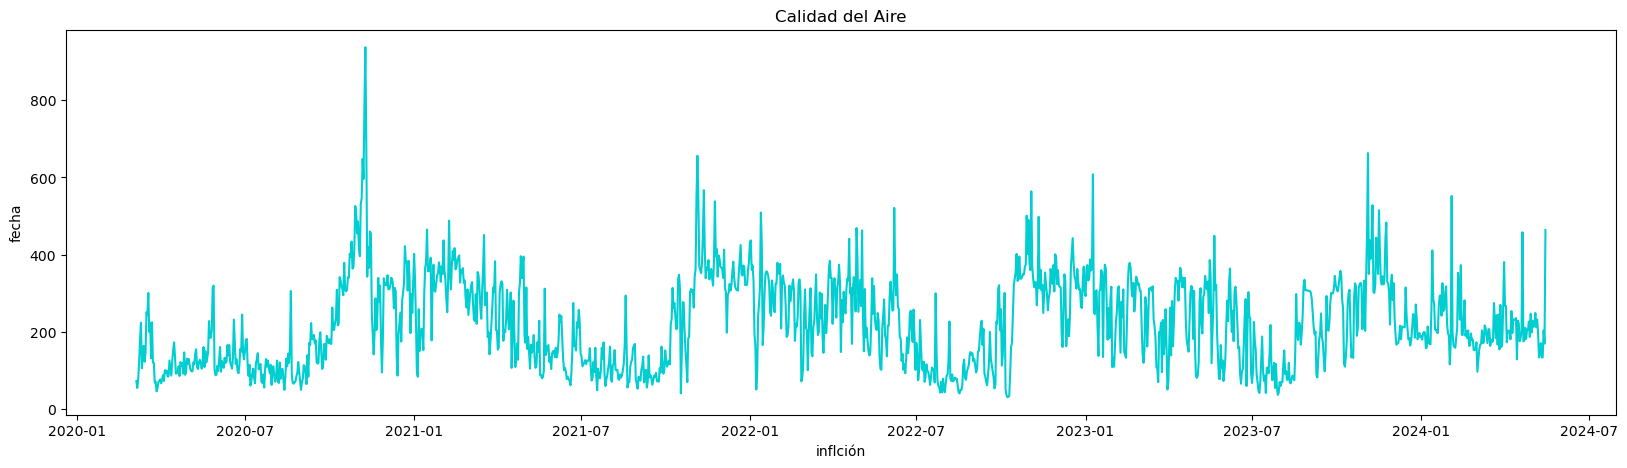

In [27]:

plt.figure(figsize=(20,5))
plt.plot(air_quality.index, air_quality['AQI'], color="#00CED1", label="inflacion")
plt.title('Calidad del Aire')
plt.xlabel('inflción')
plt.ylabel('fecha')
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller 

adfuller_coeficents = adfuller(air_quality['AQI'])


print(f'p statistic: {adfuller_coeficents[1]}')
print(f'confidence intervals : {adfuller_coeficents[4]}')
print("La serie Temporal es estacionaria")

p statistic: 0.0002985366365661377
confidence intervals : {'1%': -3.4346623009329513, '5%': -2.8634446113978034, '10%': -2.5677839889683494}
La serie Temporal es estacionaria


# train trend 

In [29]:

import pandas as pd
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import train_test_split


def trend_analysis_function(df=None, test_size=0.2, trend_order=1):
    """
    Performs trend analysis on a time series DataFrame (df).

    Args:
        df (pd.DataFrame): The time series DataFrame with a date/time index.
        test_size (float, optional): Proportion of data for testing (default: 0.2).
        trend_order (int, optional): The order of the polynomial trend to fit (default: 1).

    Returns:
        tuple: A tuple containing two DataFrames:
            - y_train: Training data for trend analysis.
            - y_test: Testing data for trend analysis evaluation.
    """

    if df is None:
        raise ValueError("Please provide a time series DataFrame (df).")

    y = df.copy()  # Avoid modifying the original DataFrame

    # Create a DeterministicProcess object for trend components
    dp = DeterministicProcess(
        index=df.index,
        constant=False,
        order=trend_order,
        drop=True  # Remove trend components from X
    )
    X = dp.in_sample()  # Get the trend design matrix

    # Handle potential seasonality (consider using CalendarSeasonality from statsmodels.tsa.deterministic)
    # You might want to uncomment and modify this section if your data exhibits seasonality.
    # seasonality = CalendarFourier(freq="infer", order=1)  # Adjust order as needed
    # X = pd.concat([X, seasonality.in_sample(df.index)], axis=1)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Convert to DataFrames for consistency
    X_train = pd.DataFrame(X_train, index=X_train.index)
    X_test = pd.DataFrame(X_test, index=X_test.index)
    y_train = pd.DataFrame(y_train, index=y_train.index)
    y_test = pd.DataFrame(y_test, index=y_test.index)

    return X_train, X_test, y_train, y_test


In [30]:
X_train, X_test, y_train, y_test = trend_analysis_function(df=air_quality, test_size=0.15, trend_order=1)


In [31]:
X_train.head()

,trend
Date,
2020-03-05,1.0
2020-03-06,2.0
2020-03-07,3.0
2020-03-08,4.0
2020-03-09,5.0


In [32]:
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

random_f_model = RandomForestRegressor(n_estimators=200, criterion='squared_error', 
                                       max_depth=100, bootstrap= True, verbose=True)

Linear_R_model = LinearRegression()

model_trend = Linear_R_model.fit(X_train, y_train)

trend_fit =  pd.DataFrame(
    model_trend.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

trend_predict = pd.DataFrame(
    model_trend.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)



In [33]:
def metrics_to_eval(real_val,fit_val):                          ## real_val is the y_train and fit_val is a fiv value
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    
    resid2=r2_score(real_val, fit_val)
    mean_abs = mean_absolute_error(real_val, fit_val)
    squared_err = mean_squared_error(real_val, fit_val)
    
    print('the r2 score is:', resid2)
    print('the mean absolute error is:', mean_abs)
    print('the mean squared error is:', squared_err)

metrics_to_eval(y_train, trend_fit)


the r2 score is: 0.009235207268623813
the mean absolute error is: 98.18093068780664
the mean squared error is: 13625.073745787024


In [34]:
metrics_to_eval(y_test, trend_predict)

the r2 score is: -0.01810046791430664
the mean absolute error is: 69.40997171250717
the mean squared error is: 7958.941631382681


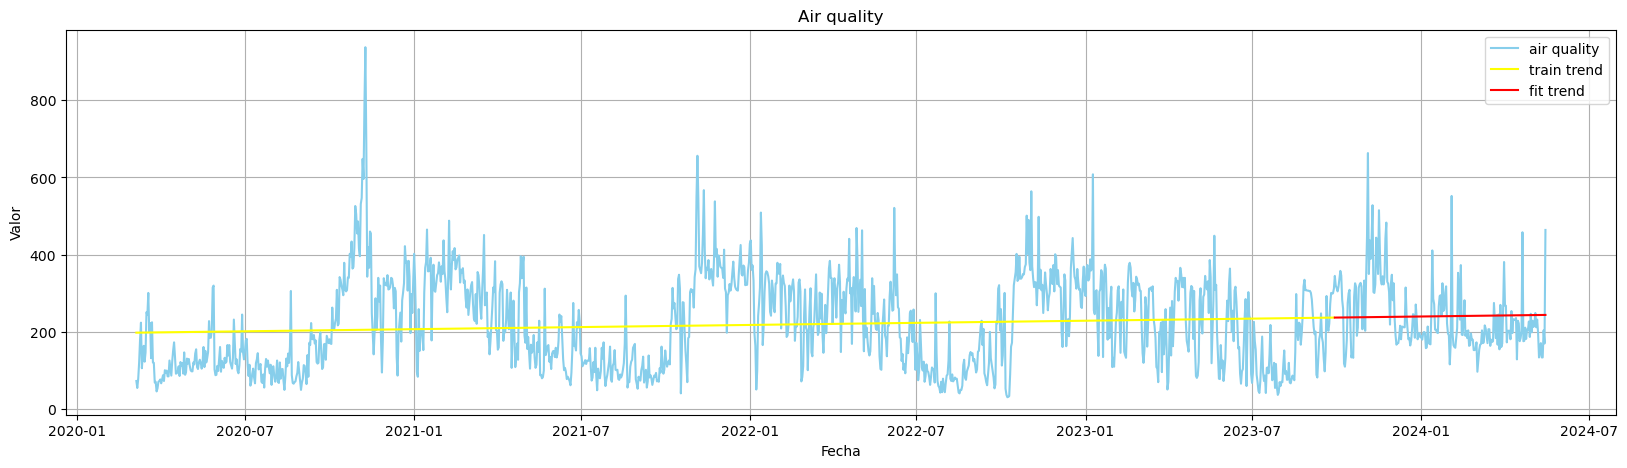

In [35]:
plt.figure(figsize=(20,5))
plt.plot(air_quality.index, air_quality, color='skyblue', label='air quality')
plt.plot(trend_fit, color="yellow", label='train trend')
plt.plot(trend_predict, color="red", label='fit trend')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('Air quality')
plt.grid(True)
plt.show()

# seasonal analysis with 

In [36]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import datetime as dt

In [37]:
week_number = dt.date(2010, 6, 16).isocalendar()[1]
print(f"Week number: {week_number}")

Week number: 24


In [38]:
X_season = pd.DataFrame(index=air_quality.index)


X_season['date'] = air_quality.index
X_season['day_week'] = air_quality.index.dayofweek
X_season['quarter'] = air_quality.index.quarter
X_season['month'] = air_quality.index.month
X_season['year'] = air_quality.index.year
X_season['day_of_year']= air_quality.index.dayofyear
X_season['day_of_month'] = air_quality.index.day
X_season['week'] = air_quality.index.isocalendar().week

del X_season['date']

X_season.head()

,day_week,quarter,month,year,day_of_year,day_of_month,week
Date,,,,,,,
2020-03-05,3,1,3,2020,65,5,10
2020-03-06,4,1,3,2020,66,6,10
2020-03-07,5,1,3,2020,67,7,10
2020-03-08,6,1,3,2020,68,8,10
2020-03-09,0,1,3,2020,69,9,11


In [39]:
xgbost_model = XGBRegressor(objective='reg:linear', n_estimators=100)
xgbost_model.fit(X_season, air_quality['AQI'])

c:\Users\eduar\anaconda3\envs\vizbuilder\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

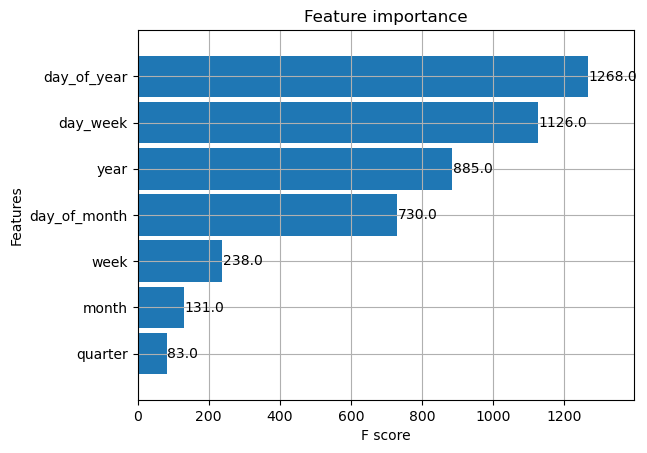

In [40]:
seasonal_importance = plot_importance(xgbost_model, height=0.9)
seasonal_importance

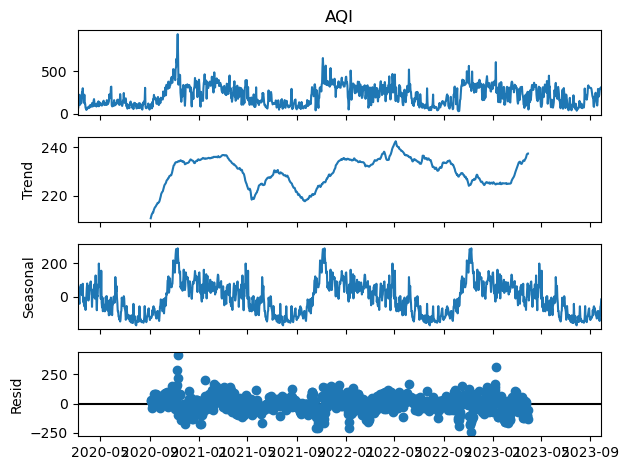

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decom = seasonal_decompose(y_train['AQI'], model='additive',extrapolate_trend=0, period=365)

_=  seasonal_decom.plot()

In [ ]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


In [ ]:
fourier_feat = fourier_features(index=y_train.index, freq=365, order=40)


In [ ]:
fourier_test = fourier_features(index=y_test.index, freq=365, order=40)

In [ ]:
fourier_feat.head()

,sin_365_1,cos_365_1,sin_365_2,cos_365_2,sin_365_3,cos_365_3,sin_365_4,cos_365_4,sin_365_5,cos_365_5,...,sin_365_56,cos_365_56,sin_365_57,cos_365_57,sin_365_58,cos_365_58,sin_365_59,cos_365_59,sin_365_60,cos_365_60
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2020-03-06,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298,...,0.821477,0.570242,0.831171,0.556017,0.840618,0.541628,0.849817,0.527078,0.858764,0.512371
2020-03-07,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220,...,0.936881,-0.349647,0.924291,-0.381689,0.910605,-0.413279,0.895839,-0.444378,0.880012,-0.474951
2020-03-08,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205105,0.978740,0.255353,0.966848,...,0.247022,-0.969010,0.196673,-0.980469,0.145799,-0.989314,0.094537,-0.995521,0.043022,-0.999074
2020-03-09,0.068802,0.997630,0.137279,0.990532,0.205105,0.978740,0.271958,0.962309,0.337523,0.941317,...,-0.655156,-0.755493,-0.705584,-0.708627,-0.752667,-0.658401,-0.796183,-0.605056,-0.835926,-0.548843


In [ ]:
seasonal_model  = Linear_R_model.fit(fourier_feat, y_train)

seasonal_fit =  pd.DataFrame(
    seasonal_model.predict(fourier_feat),
    index=y_train.index,
    columns=y_train.columns
)

seasonal_predict =  pd.DataFrame(
    seasonal_model.predict(fourier_test),
    index=y_test.index,
    columns=y_test.columns
)



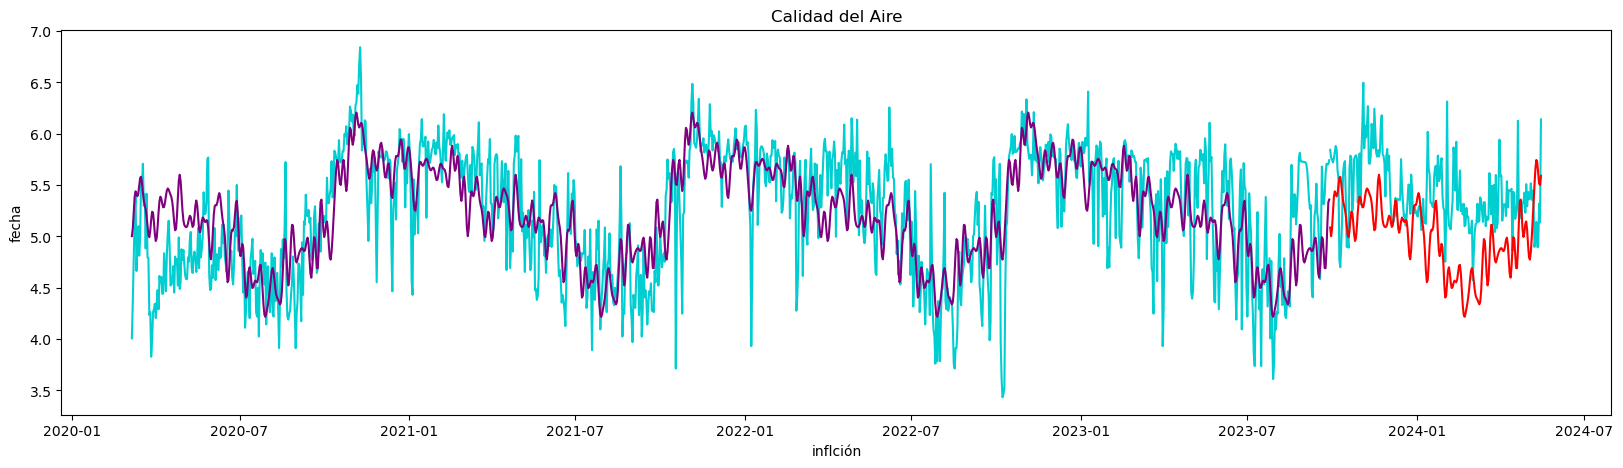

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_train.index[1:] , y_train[1:], color="#00CED1", label="air quality")
plt.plot(y_test.index , y_test, color="#00CED1", label="test air quality")
plt.plot(seasonal_fit[1:], color='purple', label='seasonal fitted')
plt.plot(seasonal_predict, color="red", label='trend predict')
plt.title('Calidad del Aire')
plt.xlabel('inflción')
plt.ylabel('fecha')
plt.show()  

In [ ]:
metrics_to_eval(y_train, seasonal_fit)

the r2 score is: 0.5492089404035676
the mean absolute error is: 0.3144233029725892
the mean squared error is: 0.16134454606448564


# Arima Model

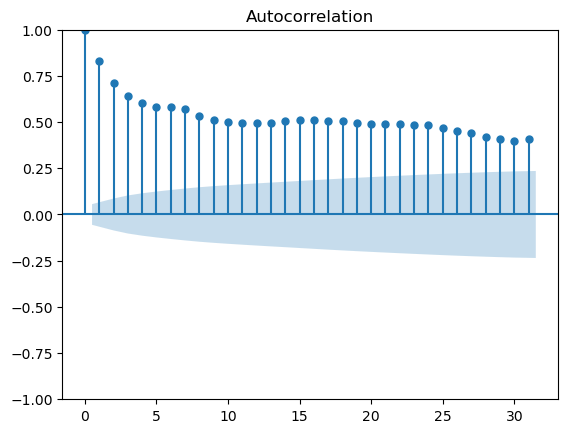

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
_= plot_acf(train['AQI'])

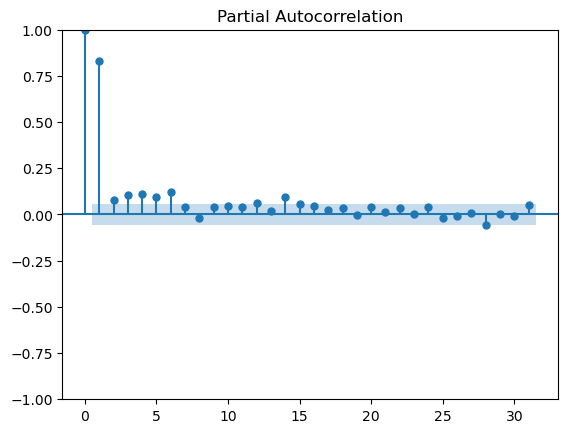

In [ ]:
_= plot_pacf(train['AQI'])

In [ ]:
from pmdarima import auto_arima, ARIMA
auto_arima(y_train)

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
model = ARIMA(y_train, order=(2,1,1))

c:\Users\eduar\anaconda3\envs\vizbuilder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\eduar\anaconda3\envs\vizbuilder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\eduar\anaconda3\envs\vizbuilder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                 1303
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -375.941
Date:                Sat, 15 Jun 2024   AIC                            759.881
Time:                        18:08:15   BIC                            780.568
Sample:                    03-05-2020   HQIC                           767.643
                         - 09-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6226      0.027     23.007      0.000       0.570       0.676
ar.L2         -0.0506      0.026     -1.980      0.048      -0.101      -0.001
ma.L1         -0.9070      0.017    -53.230      0.000      -0.940      -0.874
sigma2         0.1043      0.003     34.924      0.000       0.098       0.110
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               348.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from sklearn.metrics import r2_score
fited_values = results.fittedvalues

r2_score(y_train[1:], fited_values[1:])

0.7081988967097339

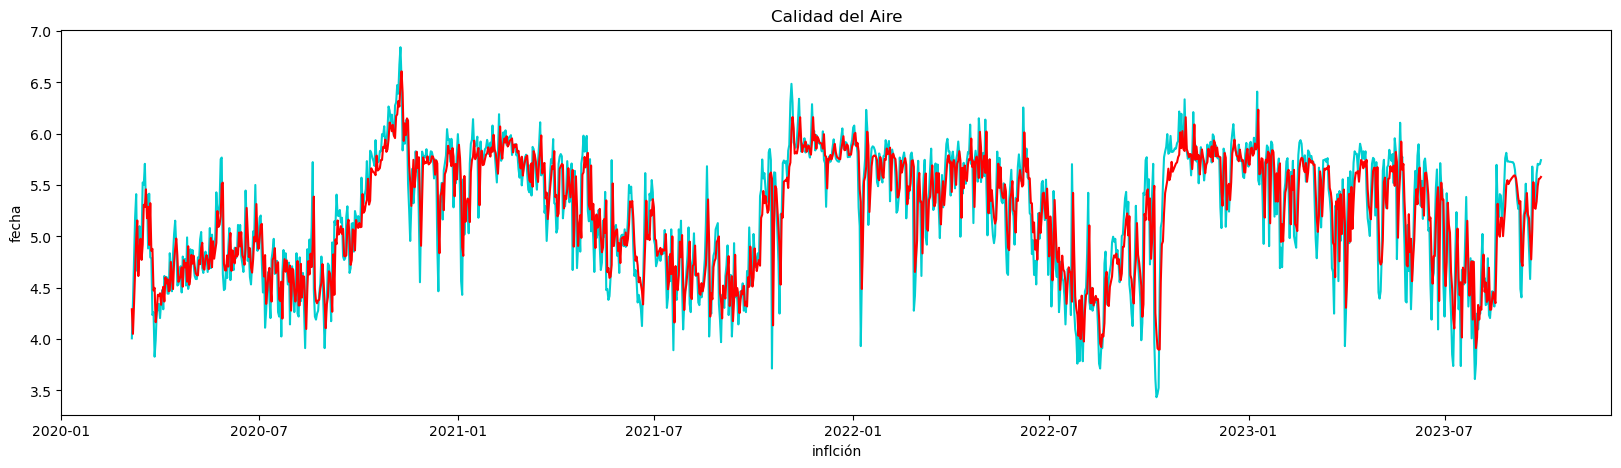

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_train.index[1:] , y_train[1:], color="#00CED1", label="inflacion")
plt.plot(fited_values[1:], color='red')
plt.title('Calidad del Aire')
plt.xlabel('inflción')
plt.ylabel('fecha')
plt.show()  

In [ ]:
# Forecast   
periods = len(y_test.index)

forecast = results.get_forecast(steps=periods)

pred = forecast.predicted_mean 
conf_int = forecast.conf_int() 

In [ ]:
conf_int.head()

,lower AQI,upper AQI
2023-09-29,4.985919,6.251582
2023-09-30,4.761214,6.317589
2023-10-01,4.659049,6.333507
2023-10-02,4.605658,6.341222
2023-10-03,4.574046,6.348756


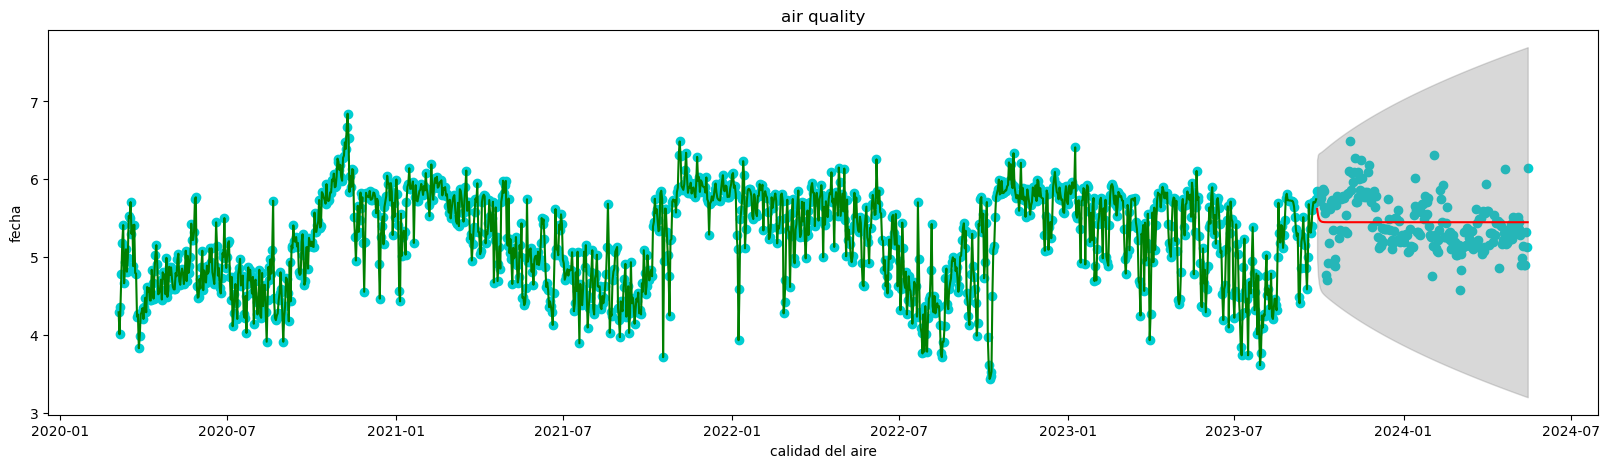

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(air_quality.index, air_quality, color="#00CED1", label="air quality")
plt.fill_between(conf_int.index, conf_int['lower AQI'], conf_int['upper AQI'], color='gray', alpha=0.3, label='Intervalo de Confianza')
plt.plot(pred, color='red', label='predict')
plt.plot(y_train, color='green', label='prediction')
plt.title('air quality')
plt.xlabel('calidad del aire')
plt.ylabel('fecha')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.088723,0.765807
2,0.212870,0.899034
3,0.343016,0.951745
4,0.602171,0.962822
5,0.728050,0.981394
6,1.625886,0.950698
7,6.836627,0.446086
8,6.917663,0.545542
9,8.785851,0.457272
10,8.854914,0.545926


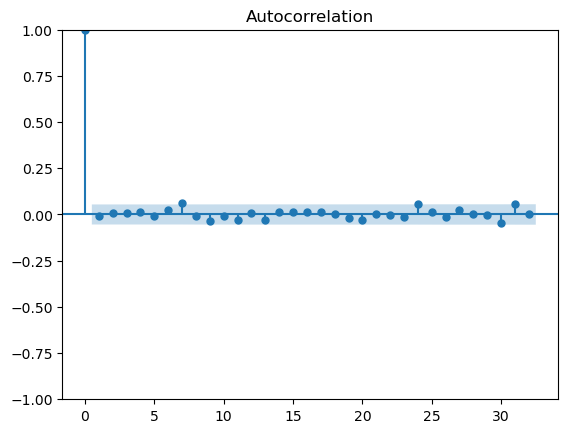

In [ ]:
_= plot_acf(residuals)

# XGBOOST model 

In [ ]:
del X_season['quarter']
del X_season['month']
del X_season['week']
del X_season['day_of_month']

In [ ]:
Xg_train, Xg_test =train_test_split(X_season, test_size=0.15, shuffle=False)

xgbost_model.fit(Xg_train, y_train)

c:\Users\eduar\anaconda3\envs\vizbuilder\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
xg_fit =  pd.DataFrame(
    xgbost_model.predict(Xg_train),
    index=y_train.index,
    columns=y_train.columns
)

xg_predict =  pd.DataFrame(
    xgbost_model.predict(Xg_test),
    index=y_test.index,
    columns=y_test.columns)

In [ ]:
metrics_to_eval(y_train, xg_fit)

the r2 score is: 0.9823532626671336
the mean absolute error is: 0.05724624383114529
the mean squared error is: 0.006316018838171901


In [ ]:
metrics_to_eval(y_test, xg_predict)

the r2 score is: -1.1507743843914002
the mean absolute error is: 0.37020432773975576
the mean squared error is: 0.2363809357581311


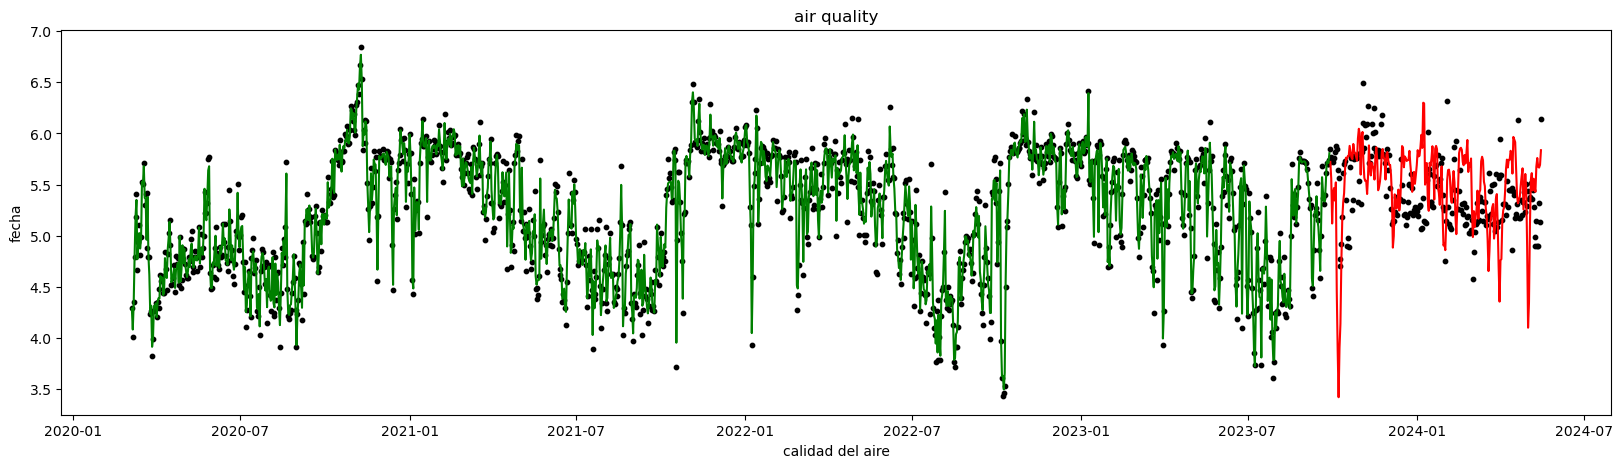

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(air_quality.index, air_quality, color="black", label="air quality", s=10)
plt.plot(xg_predict, color='red', label='predict')
plt.plot(xg_fit, color='green', label='prediction')
plt.title('air quality')
plt.xlabel('calidad del aire')
plt.ylabel('fecha')
plt.show()

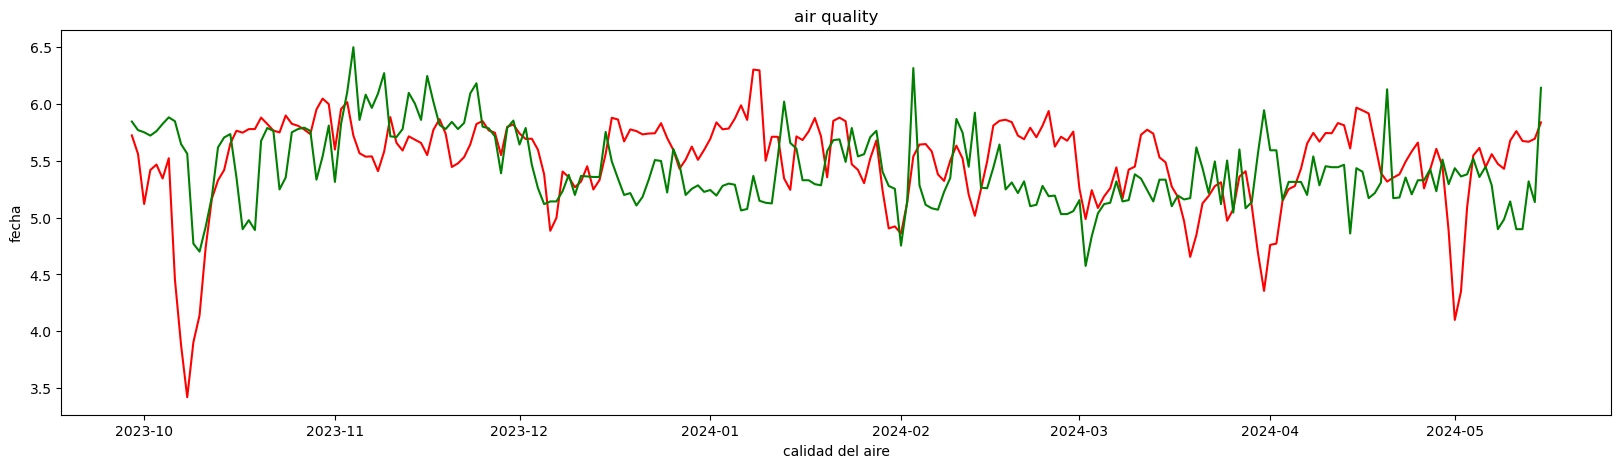

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(xg_predict, color='red', label='predict')
plt.plot(y_test, color='green', label='prediction')
plt.title('air quality')
plt.xlabel('calidad del aire')
plt.ylabel('fecha')
plt.show()